`2021-05-04`

This program loads waveforms from a .seq file and plots the pulse sequence 

In [2]:
using PyPlot

## Defining structures

Constant and unit

In [3]:
const i = complex(0.,1.);

Data structure

In [4]:
struct RF{T<:AbstractFloat}
    id::Int
    mag_id::Int
    phase_id::Int
    inRotatingFrame::Bool
    amplitude::T
    frequencyOffset::T
    phase::T
    delay::Int
    ω1_array::Array{T}
end

In [5]:
struct TRAP{T<:AbstractFloat}
    id::Int
    amplitude::T
    rise::Int
    flat::Int
    fall::Int
    delay::Int
end

In [6]:
struct DELAYS
    id::Int
    delay::Int
end

In [7]:
struct ADC
    id::Int
    num::Int
    dwell::Int
    delay::Int
    freq::Float64
    phase::Float64
end

In [8]:
struct BLOCKS
    id::Int
    D::Int
    RF::Int
    GX::Int
    GY::Int
    GZ::Int
    ADC::Int
    EXT::Int
end

## Selecting a seq file

In [9]:
fileName = "epi_se.seq"
info = readlines(fileName);

## Loading BLOCKS from .seq file

In [10]:
function addBLOCK(lineNumber)
    tmp1 = info[lineNumber]
    tmp2 = split(tmp1)
    id = parse(Int,tmp2[1])
    d0 = parse(Int,tmp2[2])
    rf0 = parse(Int,tmp2[3])
    gx0 = parse(Int,tmp2[4])
    gy0 = parse(Int,tmp2[5])
    gz0 = parse(Int,tmp2[6])
    adc0 = parse(Int,tmp2[7])
    ext0 = parse(Int,tmp2[8])
    block1 = BLOCKS(id,d0,rf0,gx0,gy0,gz0,adc0,ext0);
    return block1
end;

In [11]:
BLOCKlineNumber = 1
while (info[BLOCKlineNumber] !="[BLOCKS]")
    global BLOCKlineNumber +=1
end
BLOCKlineNumber += 1
BLOCKlineNumberEnd = BLOCKlineNumber
while (info[BLOCKlineNumberEnd] !="")
    global BLOCKlineNumberEnd +=1
end
BLOCKlineNumberEnd -= 1;

nn = BLOCKlineNumberEnd-BLOCKlineNumber+1
BLOCKSarray = Array{BLOCKS,1}(undef, nn)
for cnt = 1:nn
    block1 = addBLOCK(BLOCKlineNumber+cnt-1)
    BLOCKSarray[block1.id] = block1
end

## Loading ADC from .seq file

In [12]:
function addADC(lineNumber)
    tmp1 = info[lineNumber]
    tmp2 = split(tmp1)
    id = parse(Int,tmp2[1])
    num = parse(Int,tmp2[2])
    dwell = parse(Int,tmp2[3])
    delay = parse(Int,tmp2[4])
    freq = parse(Float64,tmp2[5])
    phase = parse(Float64,tmp2[6])
    adc1 = ADC(id, num, dwell, delay, freq, phase);
    return adc1
end;

In [13]:
ADClineNumber = 1
while (info[ADClineNumber] !="[ADC]")&&(ADClineNumber<length(info))
    global ADClineNumber +=1
end
if ADClineNumber<length(info)
    ADClineNumber += 1
    ADClineNumberEnd = ADClineNumber
    while (info[ADClineNumberEnd] !="")
        global ADClineNumberEnd +=1
    end
    ADClineNumberEnd -= 1;

    nn = ADClineNumberEnd-ADClineNumber+1
    ADCarray = Array{ADC,1}(undef, nn)
    for cnt = 1:nn
        adc1 = addADC(ADClineNumber+cnt-1)
        ADCarray[adc1.id] = adc1
    end
end

## Loading DELAYS array from .seq file

In [14]:
function addDELAYS(lineNumber)
    tmp1 = info[lineNumber]
    tmp2 = split(tmp1)
    id = parse(Int,tmp2[1])
    delay = parse(Int,tmp2[2])
    delay1 = DELAYS(id, delay);
    return delay1
end;

In [15]:
DELAYSlineNumber = 1
while (info[DELAYSlineNumber] !="[DELAYS]")&&(DELAYSlineNumber<length(info))
    global DELAYSlineNumber +=1
end
if DELAYSlineNumber<length(info)
    DELAYSlineNumber += 1
    DELAYSlineNumberEnd = DELAYSlineNumber
    while (info[DELAYSlineNumberEnd] !="")
        global DELAYSlineNumberEnd +=1
    end
    DELAYSlineNumberEnd -= 1;

    nn = DELAYSlineNumberEnd-DELAYSlineNumber+1
    DELAYSarray = Array{DELAYS,1}(undef, nn)
    for cnt = 1:nn
        delay1 = addDELAYS(DELAYSlineNumber+cnt-1)
        DELAYSarray[delay1.id] = delay1
    end
end

## Loading TRAP waveforms from .seq file

In [16]:
function addTRAP(lineNumber)
    tmp1 = info[lineNumber]
    tmp2 = split(tmp1)
    id = parse(Int,tmp2[1])
    amplitude = parse(Float64,tmp2[2])
    rise = parse(Int,tmp2[3])
    flat = parse(Int,tmp2[4])
    fall = parse(Int,tmp2[5])
    delay = parse(Int,tmp2[6])
    trap1 = TRAP{Float64}(id, amplitude, rise, flat, fall, delay);
    return trap1
end;

In [17]:
TRAPlineNumber = 1
while (info[TRAPlineNumber] !="[TRAP]")&&(TRAPlineNumber<length(info))
    global TRAPlineNumber +=1
end
if TRAPlineNumber<length(info)
    TRAPlineNumber += 1
    TRAPlineNumberEnd = TRAPlineNumber
    while (info[TRAPlineNumberEnd] !="")
        global TRAPlineNumberEnd +=1
    end
    TRAPlineNumberEnd -= 1;

    nn = TRAPlineNumberEnd-TRAPlineNumber+1
    TRAParrays = Array{TRAP,1}(undef, nn)
    for cnt = 1:nn
        trap1 = addTRAP(TRAPlineNumber+cnt-1)
        TRAParrays[trap1.id] = trap1
    end
end

## Loading RF waveforms from .seq file

In [18]:
function whereIsShapeID(shape_id)
    linenumber=0;
    for cnt = 1:length(info)
        if occursin("shape_id", info[cnt])
            if parse(Int,split(info[cnt])[2]) == shape_id
                linenumber = cnt;
            end
        end
    end
    return linenumber
end

function loadShape(shape_id)
    linenumber = whereIsShapeID(shape_id)
    tmp = split(info[linenumber+1])
    rf1array= Float64[];
    if tmp[1] == "num_samples"
        waveform1_sampleN = parse(Int,tmp[2])
        cnt = linenumber +2;
        while (info[cnt] != "")
            append!(rf1array, parse(Float64,info[cnt]))
            cnt += 1;
        end
    end
    rf1array_r1 = rf1array[1:2]
    for cnt = 3:length(rf1array)
        t2 = rf1array[cnt-2]
        t1 = rf1array[cnt-1]
        tcurrent = rf1array[cnt]
        if (t1==t2)
            t12 = repeat([t1], Int(tcurrent))
            append!(rf1array_r1, t12)
        else
            append!(rf1array_r1, tcurrent)
        end
    end
    shapeArray = cumsum(rf1array_r1,dims=1)
    return shapeArray
end;

In [19]:
function addRF(lineNumber)
    tmp1 = info[lineNumber]
    tmp2 = split(tmp1)
    id = parse(Int,tmp2[1])
    amplitude = parse(Float64,tmp2[2])
    mag_id = parse(Int,tmp2[3])
    phase_id = parse(Int,tmp2[4])
    delay = parse(Int,tmp2[5])
    freq = parse(Float64,tmp2[6])
    phase = parse(Float64,tmp2[7])
    magShape = loadShape(mag_id)
    phaseShape = loadShape(phase_id)
    rf = magShape .* exp.(i*2*π.*phaseShape)
    rfExcitation = RF{Float64}(id, mag_id, phase_id, true, amplitude, freq, phase, delay, real.(rf));
    return rfExcitation
end;

In [20]:
RFlineNumber = 1
while (info[RFlineNumber] !="[RF]")&&(RFlineNumber<length(info))
    global RFlineNumber +=1
end
if RFlineNumber<length(info)
    RFlineNumber += 1
    RFlineNumberEnd = RFlineNumber
    while (info[RFlineNumberEnd] !="")
        global RFlineNumberEnd +=1
    end
    RFlineNumberEnd -= 1;

    nn = RFlineNumberEnd-RFlineNumber+1
    RFarrays = Array{RF,1}(undef, nn)
    for cnt = 1:nn
        rf1 = addRF(RFlineNumber+cnt-1)
        RFarrays[rf1.id] = rf1
    end
end

## Computing the duration for each BLOCK

In [22]:
getDuration(x::RF) =  x.delay + length(x.ω1_array)
getDuration(x::TRAP) = x.delay + x.rise + x.flat + x.fall
getDuration(x::DELAYS) = x.delay
getDuration(x::ADC) = x.delay + 0.001*(x.dwell * x.num)
function getDuration(x::BLOCKS)
    duration = 0;
    fieldsInStruct=fieldnames(BLOCKS)
    for cnt = 2: length(fieldsInStruct)
        value=getfield(x, fieldsInStruct[cnt])
        if value > 0
            if cnt == 2 
                duration = max(duration, getDuration(DELAYSarray[value]))
            end
            if cnt == 3 
                duration = max(duration,getDuration(RFarrays[value]))
            end
            if cnt == 4 
                duration = max(duration,getDuration(TRAParrays[value]))
            end
            if cnt == 5 
                duration = max(duration,getDuration(TRAParrays[value]))
            end
            if cnt == 6 
                duration = max(duration,getDuration(TRAParrays[value]))
            end
            if cnt == 7 
                duration = max(duration,getDuration(ADCarray[value]))
            end
        end
    end
    return duration
end;

In [23]:
DurationArray = zeros(Int, length(BLOCKSarray));
for cnt = 1:length(BLOCKSarray)
    tmp = getDuration(BLOCKSarray[cnt])
    DurationArray[cnt]=Int(ceil(tmp))
end
TimeStampArray = cumsum(DurationArray);

## Plotting pulse sequence

In [24]:
function plotEACH(x::TRAP, np)
    output = zeros(np)
    output[x.delay + 1 : x.delay + x.rise] = LinRange(0,x.amplitude,x.rise)
    output[x.delay + x.rise + 1 : x.delay + x.rise + x.flat] .= x.amplitude
    output[x.delay + x.rise + x.flat + 1 : x.delay + x.rise + x.flat + x.fall] = LinRange(x.amplitude,0,x.fall)
    return output
end

function plotEACH(x::RF, np)
    output = zeros(np)
    output[x.delay + 1 : x.delay + length(x.ω1_array)] = x.ω1_array * x.amplitude
    return output
end

function plotEACH(x::ADC, np)
    output = zeros(np)
    dw = div(x.dwell,1000)
    output[x.delay + 1 : dw : x.delay + (dw*x.num)] .= 1. 
    return output
end;


In [25]:
seqRF = zeros(TimeStampArray[end])
seqADC = zeros(TimeStampArray[end])
seqGx = zeros(TimeStampArray[end])
seqGy = zeros(TimeStampArray[end])
seqGz = zeros(TimeStampArray[end])

fieldsInStruct=fieldnames(BLOCKS)

for cntB = 1:length(BLOCKSarray)
    thisBLOCK = BLOCKSarray[cntB]
    for cnt = 3: length(fieldsInStruct)
        value=getfield(thisBLOCK, fieldsInStruct[cnt])
        if value > 0
            if cnt == 3 
                tmp = plotEACH(RFarrays[value], DurationArray[cntB])
                seqRF[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]] = tmp
            end
            if cnt == 4 
                tmp = plotEACH(TRAParrays[value], DurationArray[cntB])
                seqGx[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]] = tmp
            end
            if cnt == 5 
                tmp = plotEACH(TRAParrays[value], DurationArray[cntB])
                seqGy[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]] = tmp
            end
            if cnt == 6 
                tmp = plotEACH(TRAParrays[value], DurationArray[cntB])
                seqGz[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]] = tmp
            end
            if cnt == 7 
                tmp = plotEACH(ADCarray[value], DurationArray[cntB])
                seqADC[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]] = tmp
            end
        end
    end 
end


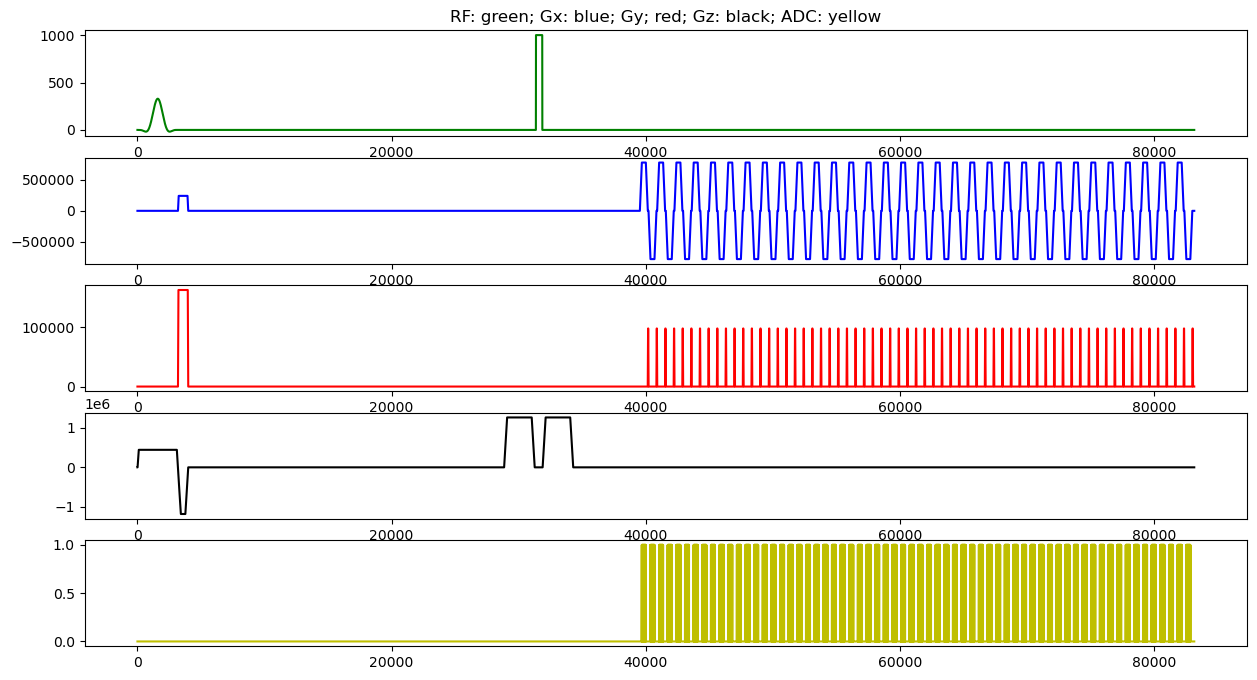

In [28]:
figure(1, figsize=(15,8))
subplot(5,1,1);
plot(seqRF,color="g"); title("RF: green; Gx: blue; Gy; red; Gz: black; ADC: yellow")
subplot(5,1,2);
plot(seqGx, color="b"); 
subplot(5,1,3);
plot(seqGy, color="r")
subplot(5,1,4);
plot(seqGz, color="k")
subplot(5,1,5);
plot(seqADC, color="y"); 

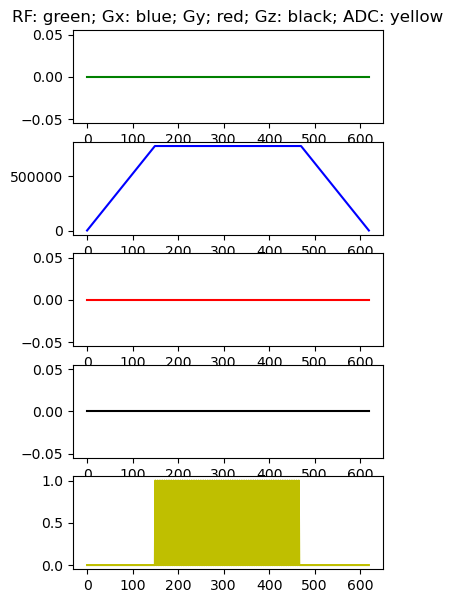

In [29]:
cntB = 96
figure(1, figsize=(4,7))
subplot(5,1,1);
plot(seqRF[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]], color="g"); 
title("RF: green; Gx: blue; Gy; red; Gz: black; ADC: yellow")
subplot(5,1,2);
plot(seqGx[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]], color="b"); 
subplot(5,1,3);
plot(seqGy[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]], color="r")
subplot(5,1,4);
plot(seqGz[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]], color="k")
subplot(5,1,5);
plot(seqADC[TimeStampArray[cntB]-DurationArray[cntB]+1:TimeStampArray[cntB]], color="y"); 